# 16 Getting flux limits from the API
## Flux limits for a shot

After installing the HETDEX API we can import the tools to access the flux limits

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt

from astropy.table import Table

from hetdex_api.survey import Survey
from hetdex_api.flux_limits.shot_sensitivity import ShotSensitivity

# has to be here, as HETDEX API sets a backend
%matplotlib inline

In [2]:
from numpy import linspace, ones, arange, repeat, meshgrid, logical_not

In [3]:
from numpy.ma import masked_where

In [4]:
from numpy.random import uniform, choice

To start we need to pick a datevobs. Let's use the survey table, as described in the first notebook.

In [5]:
survey = Survey("hdr2.1")
survey_table = survey.return_astropy_table()
survey_table[-10:]

shotid,field,objid,date,obsid,ra,dec,pa,n_ifu,fwhm_virus,fwhm_virus_err,response_4540,ambtemp,datevobs,dewpoint,exptime,humidity,mjd,nstars_fit_fwhm,obsind,pressure,structaz,time,trajcdec,trajcpa,trajcra,shot_flag,fluxlimit_4540
int64,bytes12,bytes18,int32,int32,float64,float64,float64,int32,float32,float32,float32,float32,bytes12,float32,float32,float32,float32,int32,int32,float32,float32,bytes7,float32,float32,float32,bool,float64
20200625017,dex-spring,DEXsp4017,20200625,17,210.738079,54.380782,299.624902,70,2.7147236,0.7351299,0.0657,19.393888,20200625v017,8.528889,427.93527,46.422,59025.22,140,1,804.5381,323.24152,0517466,54.38,297.93137,210.738,True,3.4022886355000006e-16
20200625018,dex-spring,DEXsp3967,20200625,18,220.267192,53.446167,299.593584,70,1.9157426,0.565008,0.1493,19.396667,20200625v018,8.218889,607.68256,46.019,59025.24,16,1,804.5381,323.24152,0545172,53.446377,297.93137,220.26654,True,1.0518607855000001e-16
20200625019,dex-spring,DEXsp7185,20200625,19,231.379347,53.476017,299.621378,70,1.9826775,0.25718248,0.1344,19.47,20200625v019,7.553889,367.87448,42.96,59025.266,27,1,804.301,323.24152,0621492,53.475475,297.93137,231.37999,True,9.963181855e-17
20200625020,dex-spring,DEXsp6525,20200625,20,234.140324,53.98981,299.617724,70,1.8120736,0.32785416,0.1523,19.15611,20200625v020,7.5394444,487.69955,43.635,59025.28,37,1,804.301,323.24152,0645237,53.989723,297.93137,234.13976,True,9.209148355000002e-17
20200625021,dex-spring,DEXsp6671,20200625,21,240.172723,53.54772,299.621378,70,1.6585162,0.38814068,0.1324,19.146667,20200625v021,7.551111,488.26645,43.714,59025.3,21,1,804.3688,323.24152,0715209,53.547062,297.93137,240.1725,True,9.047872855000001e-17
20200626016,dex-spring,DEXsp7175,20200626,16,230.675762,53.234764,296.974196,71,1.2604536,0.10521854,0.1537,20.10389,20200626v016,9.031111,427.66614,46.533,59026.246,43,1,804.6397,321.002,0554075,53.234367,295.3104,230.67612,True,5.863015855000002e-17
20200626017,dex-spring,DEXsp7111,20200626,17,224.852859,53.549799,296.932937,71,1.3909405,0.2306041,0.1123,19.631666,20200626v017,9.708889,367.5492,49.958,59026.266,25,1,804.7074,321.002,0622044,53.549393,295.3104,224.85326,True,7.762371355000001e-17
20200626018,dex-spring,DEXsp6508,20200626,18,233.651753,53.993989,296.924724,71,1.4448333,0.23766221,0.1245,19.502777,20200626v018,10.167222,367.12317,51.678,59026.28,38,1,804.7074,321.00192,0647072,53.993607,295.3103,233.65271,True,7.803667855000001e-17
20200626019,dex-spring,DEXsp6618,20200626,19,239.174074,53.113723,296.973253,71,1.3604825,0.2726477,0.1043,19.17389,20200626v019,11.966666,367.45407,53.376,59026.3,27,1,804.6397,321.00192,0711352,53.113827,295.3103,239.17342,True,8.676019855000001e-17


Let pick datevobs ``20190209v024`` and an S/N cut of 5.0 as an example.

In [6]:
datevobs = "20190209v024"
sncut = 5.0

You can specify a `flim_model`. This sets the scaling between the noise from the fibers and the completeness. The current version is `v2`. If you leave this out it will default to the latest version.

In [7]:
shot_sens_v2 = ShotSensitivity(datevobs, flim_model="v2")

We can use the `TangentPlane` object in the `ShotSensitivity` class to generate some points in the focal plane just to give us some ra/dec values to generate limits for. Here `x` and `y` are arcseconds in the focal plane (but swapped to match the definition of x,y in the IFUs).

In [40]:
x = uniform(-600., 600.0, 2000)
y = uniform(-600., 600.0, 2000)
wave = uniform(3700, 5400, 2000)
ra, dec = shot_sens_v2.tp.xy2raDec(x, y)

Find the flux at 50\% completeness.

In [41]:
f50 = shot_sens_v2.get_f50(ra, dec, wave, sncut)

100%|██████████| 14122/14122 [00:00<00:00, 158033.65it/s]


Select points with sensible flux limits (i.e. falling in IFUs and not masked)

In [42]:
ra = ra[f50 < 1e-10]
dec = dec[f50 < 1e-10]
wave = wave[f50 < 1e-10]
f50 = f50[f50 < 1e-10]

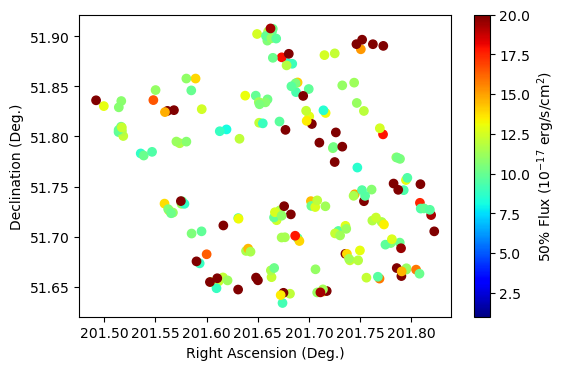

In [11]:
plt.figure(dpi=100)
plt.scatter(ra, dec, c=f50*1e17, vmin = 1, vmax = 20, cmap="jet")
plt.xlabel("Right Ascension (Deg.)")
plt.ylabel("Declination (Deg.)")
plt.colorbar(label="50% Flux (10$^{-17}$ erg/s/cm$^2$)")

You can also plot the flux limits versus wavelength like this. Below we also demonstrate how you can
include the effects of variable linewidth on the completeness by including the `linewidth` option, which
should be an array of linewidths in angstroms. Bigger linewidths cause lower completeness. If you pass `None` this
gives you the completeness for linewidths of 2.2 A.

100%|██████████| 9/9 [00:00<00:00, 548.48it/s]


Text(0, 0.5, 'Flux limit ($10^{-17}$ erg/s/cm$^2$)')

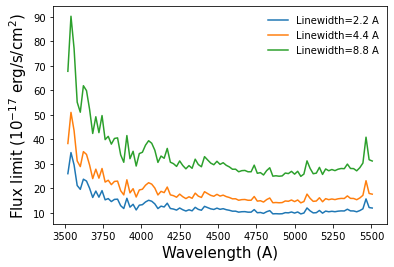

In [12]:
wls = linspace(3500.0, 5505.0, 100)


for linewidth in [2.2, 4.4, 8.8]:
    flims = shot_sens_v2.get_f50(ra[50]*ones(len(wls)), dec[50]*ones(len(wls)), 
                                 wls, sncut, linewidth=linewidth*ones(len(wls)))
    plt.plot(wls[flims < 999], 1e17*flims[flims < 999], 
            label="Linewidth={:2.1f} A".format(linewidth))


plt.legend(frameon = False)
plt.xlabel("Wavelength (A)", fontsize=15.0)
plt.ylabel("Flux limit ($10^{-17}$ erg/s/cm$^2$)", fontsize=15.0)

Or to get not the flux limit but an estimate of the 1 sigma noise in apertures, use the `direct_sigmas` option, i.e. do

In [13]:
one_sigma = shot_sens_v2.get_f50(ra, dec, wave, sncut, direct_sigmas=True)

100%|██████████| 1419/1419 [00:00<00:00, 47325.62it/s]


The noise in apertures does not depend on linewidth in our current model

In [14]:
one_sigma

array([2.44639100e-17, 2.45088841e-17, 1.87486635e-17, 2.75929698e-17,
       1.98215330e-17, 2.57477480e-17, 7.71688540e-16, 5.37023515e-17,
       2.53681833e-17, 1.75880662e-17, 2.50562898e-17, 2.48084892e-17,
       2.00372240e-17, 5.42604442e-16, 2.71818534e-17, 2.06049807e-17,
       2.42243051e-17, 1.98353541e-17, 4.60991872e-17, 1.35870554e-15,
       2.03287984e-17, 3.11742636e-17, 1.76045410e-17, 3.03957160e-17,
       2.69315821e-17, 1.85355594e-17, 1.53927050e-16, 2.45214586e-17,
       2.94368727e-17, 2.38816157e-17, 1.82233988e-17, 3.79568176e-17,
       2.74198986e-17, 1.79648886e-17, 2.06244989e-17, 4.11794603e-17,
       2.60198543e-17, 5.96269846e-17, 3.43300624e-17, 2.69723576e-17,
       3.05993155e-17, 2.70669813e-17, 2.60502462e-17, 2.31412644e-17,
       2.69050218e-17, 4.24670171e-17, 2.21889225e-17, 2.89776873e-17,
       2.25095547e-17, 2.31500799e-17, 2.15050450e-17, 2.08575205e-17,
       2.28618067e-17, 2.54732418e-17, 3.23374483e-17, 6.93547840e-16,
      

## Fraction of detected sources versus flux

To get the fraction of sources detected at a particular flux, rather than just the flux limit value one can use this method. Again we include the `linewidth` option to account for the linewidth dependence of completeness.

In [15]:
fluxes = uniform(1e-16, 5e-16, len(ra))
linewidth = uniform(2.2, 8.8, len(ra))
# Flux (cgs) RA DEC (in degrees) Wavelength (Angstrom), linewidth (Angstrom) 
compl = shot_sens_v2.return_completeness(fluxes, ra, dec, wave, sncut,
                                         linewidth = linewidth)

Text(0, 0.5, 'Completeness')

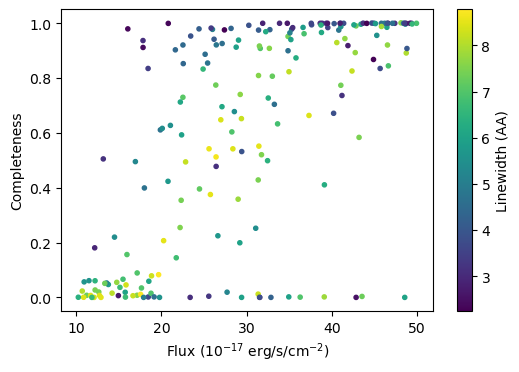

In [16]:
plt.figure(dpi=100)
ax = plt.scatter(fluxes*1e17, compl, marker=".", c=linewidth)
plt.colorbar(ax, label="Linewidth (AA)")
plt.xlabel("Flux (10$^{-17}$ erg/s/cm$^{-2}$)")
plt.ylabel("Completeness")

By definition the 50\% flux should return 50\% completeness

In [43]:
flux = shot_sens_v2.get_f50(ra[0], dec[0], 4245, sncut, linewidth=3.4)
shot_sens_v2.return_completeness(flux, ra[0], dec[0], 4245, sncut, linewidth=3.4)

100%|██████████| 9/9 [00:00<00:00, 22442.77it/s]


array([0.50000005])

Here is a plot of the completeness versus flux at some position. Note we use the flux limit computed above to define the range of the plot

Text(0, 0.5, 'Detected Fraction')

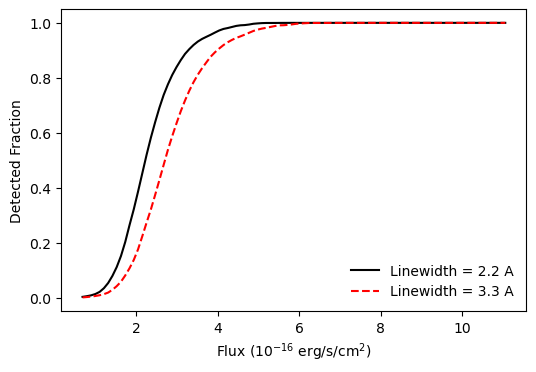

In [48]:
fluxes = linspace(0.25*flux, 4*flux, 100)
compl = shot_sens_v2.return_completeness(fluxes, ra[0], dec[0], 4245, sncut)
compl_lw3pt3 = shot_sens_v2.return_completeness(fluxes, ra[0], dec[0], 4245, sncut, linewidth=3.3)
plt.figure(dpi=100)
plt.plot(fluxes*1e16, compl, "k-", label="Linewidth = 2.2 A")
plt.plot(fluxes*1e16, compl_lw3pt3, "r--", label="Linewidth = 3.3 A")

plt.legend(frameon=False)
plt.xlabel("Flux ($10^{-16}$ erg/s/cm$^2$)")
plt.ylabel("Detected Fraction")

## Generating a cube of flux limits for an IFU

We can extract a 3D cube of precomputed flux limits for an IFU like this. Note that you have to add the string `ifuslot_` to the three digit IFU slot. It's not really recommended that you do this, as it pixelizes the flux limits, but it's included if you want it or for visualisation purposes. The `nx` and `ny` sets the resolution.

In [19]:
scube_dict = {}
for slot in ['096', '085', '033']:
    scube_dict[slot] = shot_sens_v2.extract_ifu_sensitivity_cube("ifuslot_{:s}".format(slot), 
                                                                  nx=30, ny=30)

For comparison, here we'll generate the same IFUs but with twice the resolution

In [20]:
scube_dict_hires = {}
for slot in ['096', '085', '033']:
    scube_dict_hires[slot] = shot_sens_v2.extract_ifu_sensitivity_cube("ifuslot_{:s}".format(slot), 
                                                                         nx=60, ny=60)

scube_hires = shot_sens_v2.extract_ifu_sensitivity_cube("ifuslot_036", nx=60, ny=60)

The ``sigmas`` array is now a ``numpy.ma:MaskedArray`` which contains both a data array and a mask array

In [21]:
scube_dict['096'].sigmas.data[500:503, 2:5, 2:5]

array([[[9.99000000e+02, 3.73048978e-16, 1.30230936e-16],
        [1.36558291e-16, 3.96627977e-17, 2.56898595e-17],
        [4.17168198e-17, 2.40471495e-17, 2.30460480e-17]],

       [[9.99000000e+02, 3.74542115e-16, 1.30549651e-16],
        [1.37446563e-16, 3.98739718e-17, 2.57848184e-17],
        [4.19652503e-17, 2.42355406e-17, 2.31503259e-17]],

       [[9.99000000e+02, 3.72002324e-16, 1.29493679e-16],
        [1.37112713e-16, 3.97059143e-17, 2.56589142e-17],
        [4.18275781e-17, 2.42121257e-17, 2.30927694e-17]]])

In [22]:
scube_dict['096'].sigmas.mask[500:503, 2:5, 2:5]

array([[[ True, False, False],
        [False, False, False],
        [False, False, False]],

       [[ True, False, False],
        [False, False, False],
        [False, False, False]],

       [[ True, False, False],
        [False, False, False],
        [False, False, False]]])

`True` here means it is masked, `False` means the data is good. Warning!! This is the opposite convention from the mask returned from `get_f50` when you pass `None` for the wavelength

Let's plot the low res and high res flux limit cubes to compare

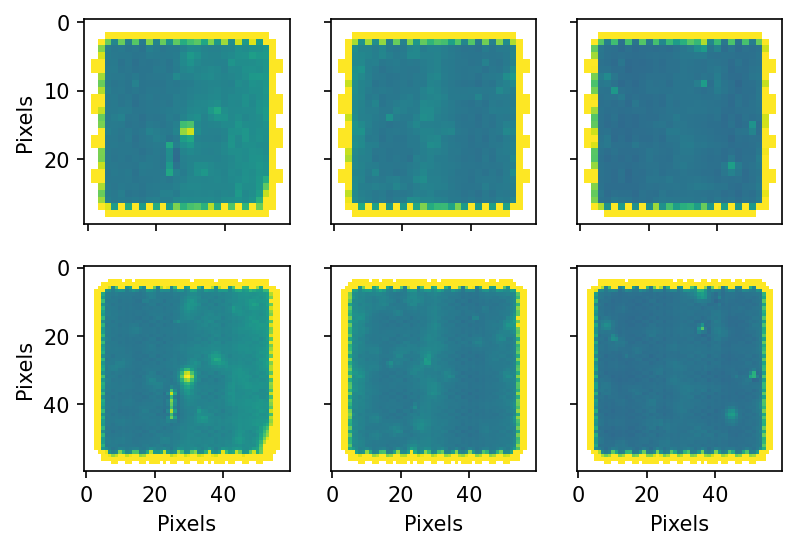

In [23]:
fig = plt.figure(dpi=150)
vrange=[5e-18, 5e-17]
gs = fig.add_gridspec(nrows=2, ncols=3)

for i, slot in enumerate(['096', '085', '033']):

    ax = fig.add_subplot(gs[0,i])
    ax.imshow(scube_dict[slot].sigmas[500, :, :], clim=vrange)
    ax.set_xlabel("Pixels")
    ax.set_ylabel("Pixels")
    ax.label_outer()

    ax = fig.add_subplot(gs[1,i])
    ax.imshow(scube_dict_hires[slot].sigmas[500, :, :], clim=vrange)
    ax.set_xlabel("Pixels")
    ax.set_ylabel("Pixels")
    ax.label_outer()

# Compare cubes to `get_f50`

Test how similar the cubes are to actually running `get_f50` on the coordinates for all the cube pixels.

100%|██████████| 177/177 [00:00<00:00, 482.24it/s]


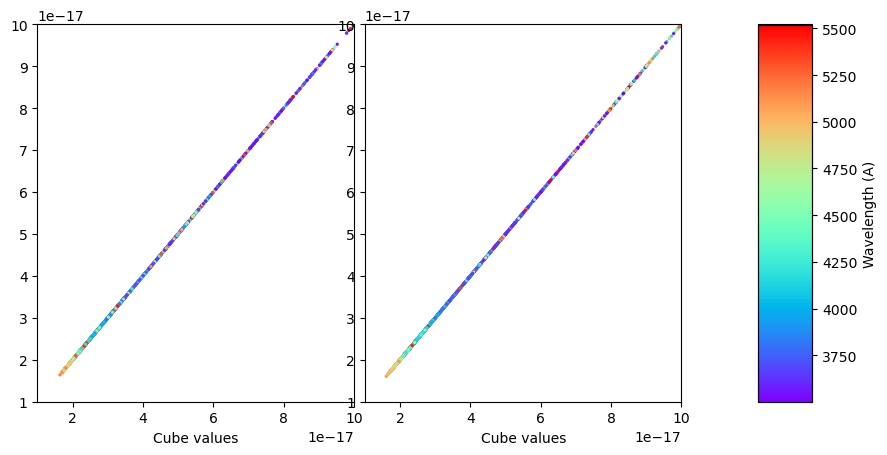

In [24]:
fig = plt.figure(dpi=100, figsize=(10,5))
gs = fig.add_gridspec(nrows=1, ncols=12)
axes = [fig.add_subplot(gs[:5]), fig.add_subplot(gs[5:10])]
cax = fig.add_subplot(gs[11])

for j, sdict in enumerate([scube_dict, scube_dict_hires]):
    for i, slot in enumerate(['096', '085', '033']):
    
        cube = sdict[slot]
        
        x = choice(cube.sigmas.shape[2], size=2000)
        y = choice(cube.sigmas.shape[1], size=2000)
        z = choice(cube.sigmas.shape[0], size=2000)

        sigmas_cube = cube.sigmas[z, y, x]
    
        ra, dec, wave = cube.wcs.wcs_pix2world(x, y, z, 0)
    
    
        sigmas_on_the_fly = shot_sens_v2.get_f50(ra, dec, wave, 1.0, 
                                                 direct_sigmas=True)
    
        m = axes[j].scatter(sigmas_cube, sigmas_on_the_fly, marker=".", s=7.,
                            c=wave, cmap="rainbow")

        axes[j].set_xlim(1e-17, 1e-16)
        axes[j].set_ylim(1e-17, 1e-16)
        axes[j].set_xlabel("Cube values")
        
        if j==1:
            plt.ylabel("On the fly values")

    plt.colorbar(m, cax=cax, label="Wavelength (A)")
    plt.plot([0, 1], [0,1], "r--", scalex=False, scaley=False)    

They agree perfectly when you're directly on the cube pixels, it's between the pixels where the limited resolution of the cubes has an impact. So if you really want flux limits on a pixelized grid you can use the `extract_ifu_sensitivity_cube` command.

## Compare grabbing whole wavelength range to passing wavelengths

Here we test passing `None` to `get_f50` for the wavelength gives an array of noise versus wavelength that is the same as requesting single flux limits for each wavelength

Grab an RA/DEC for the comparison of extracting the full noise versus wavelength to a single position.

In [25]:
ra, dec, wave = scube_hires.wcs.all_pix2world(5, 7, 800, 0)

Now grab all the flux limis versus wavelength by passing `None` for the wavelength argument

In [26]:
all_sigmas, mask = shot_sens_v2.get_f50(ra, dec, None, 5.0, direct_sigmas=True)
all_sigmas = all_sigmas[0]

Get the wavelengths corresponding to these noise values

In [27]:
junkra, junkdec, waves = cube.wcs.all_pix2world(ones(len(all_sigmas)), 
                                                ones(len(all_sigmas)), 
                                                arange(len(all_sigmas)), 0)

Then look them up individually

In [28]:
from_single_wave = shot_sens_v2.get_f50(repeat(ra, len(all_sigmas)), 
                                        repeat(dec, len(all_sigmas)), 
                                        waves, 5., direct_sigmas=True)

If everything is working these should agree

(0.0, 2e-15)

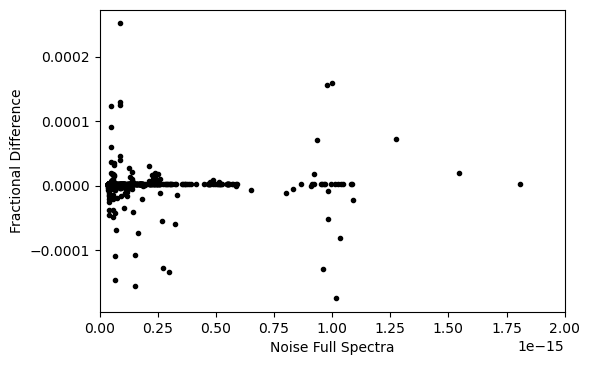

In [29]:
plt.figure(dpi=100)
ax = plt.plot(all_sigmas, (from_single_wave - all_sigmas)/all_sigmas, "k.")
plt.xlabel("Noise Full Spectra")
plt.ylabel("Fractional Difference")
plt.xlim(0, 2e-15)

## Test the galaxy mask is implemented

Let's grab some flux limits around an IFU we know has a big galaxy in it, to make sure the galaxy masking works. Again extracting the IFU cubes isn't really recommended as it pixelizes the flux limits, but it's OK for visualisation purposes.

In [30]:
s = ShotSensitivity("20200625v019")
cube = s.extract_ifu_sensitivity_cube('ifuslot_035')

Text(0, 0.5, 'Pixels')

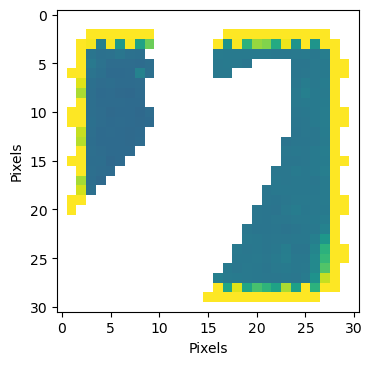

In [31]:
plt.figure(dpi=100)
plt.imshow(cube.sigmas[500, :, :], clim=vrange)
plt.xlabel("Pixels")
plt.ylabel("Pixels")

The galaxy mask should be very obvious in the image above.

## Plotting flux limits for a whole shot

Here we demonstrate how to plot the flux limits over a whole shot

In [32]:
s = ShotSensitivity("20200611v012")

You set the resolution here via the last argument to `linspace`, higher resolution takes longer to produce but looks nicer.

In [50]:
x = linspace(-600.0, 600.0, 400)
y = linspace(-600.0, 600.0, 400)

In [51]:
xgrid, ygrid = meshgrid(x, y)

In [52]:
ra, dec = s.tp.xy2raDec(xgrid, ygrid)

In [53]:
sigmas, mask = s.get_f50(ra.ravel(), dec.ravel(), None, 1.0, direct_sigmas=True)

As we didn't pass a wavelength, `sigmas` here is an array where the first axis corresponds to pairs of ra/dec positions and the second axis is the wavelength. Mask is the mask of the ra/dec pairs that are good. Grab a wavelength slice and set everything that's not in the mask to a huge value.

In [54]:
sigma_slice = sigmas[:, 500]
sigma_slice[logical_not(mask)] = 999

Now plot, remembering to reshape the array of ra/dec pairs into 2D. Note the x, y coordinates in the focal plane are rotated with respect to the IFUs. The easiest thing to do here is to pass the `WCS` object from the `ShotSensitivity` class as a projection and the it should all work.

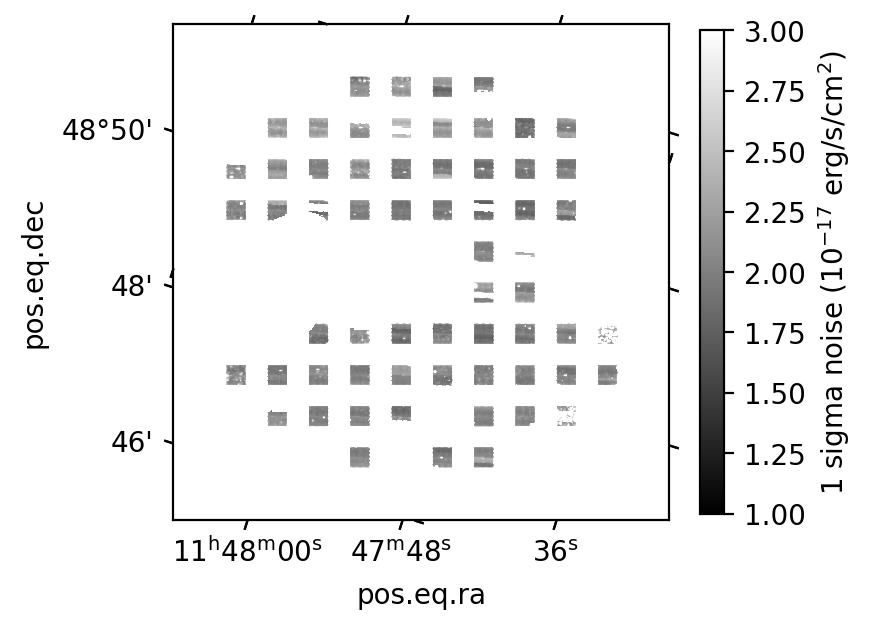

In [55]:
plt.figure(dpi=200, figsize=(4,4))
ax = plt.subplot(projection=s.tp.wcs)
im = ax.imshow(1e17*sigma_slice.reshape(len(y), len(x)), 
          clim=[1, 3], cmap="gray")
plt.colorbar(im, label="1 sigma noise (10$^{-17}$ erg/s/cm$^2$)", shrink=0.8)
plt.show()

You can clearly see the impact of the galaxy mask on the left of the above image.